In [54]:
import numpy as np
import matplotlib.pyplot as plt

import motlee.realign.frame_aligner
from motlee.utils.transform import transform, xypsi_2_transform

# Environment Setup

Example environment has overlapping maps with 50% outliers

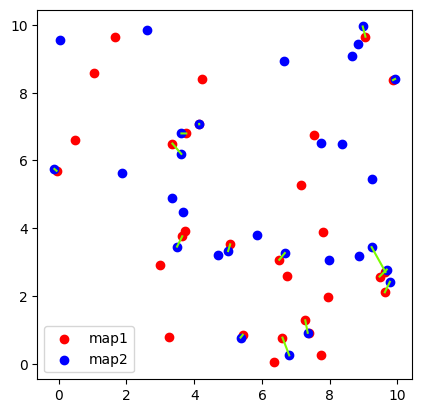

In [55]:
num_objs_overlap = 15
objs_cov = np.diag([.2**2, .2**2])
env_width_height = 10
outlier_fraction = .5
num_outliers = int((num_objs_overlap / outlier_fraction) * (1 - outlier_fraction))

inliers = np.random.random((num_objs_overlap, 2))*env_width_height
inliers1 = inliers + np.random.multivariate_normal(np.zeros(2), objs_cov, (num_objs_overlap,))
inliers2 = inliers + np.random.multivariate_normal(np.zeros(2), objs_cov, (num_objs_overlap,))
outliers1 = np.random.random([num_outliers, 2])*env_width_height
outliers2 = np.random.random([num_outliers, 2])*env_width_height

map1 = np.vstack([inliers1, outliers1])
map2 = np.vstack([inliers2, outliers2])
map2_correct = np.copy(map2)

fig, ax = plt.subplots()
ax.scatter(map1[:,0], map1[:,1], color='red')
ax.scatter(map2[:,0], map2[:,1], color='blue')
for i in range(num_objs_overlap):
    ax.plot([map1[i,0], map2[i,0]], [map1[i,1], map2[i,1]], color='lawngreen')
ax.legend(['map1', 'map2'])
ax.set_aspect('equal')

Apply random translation and rotation

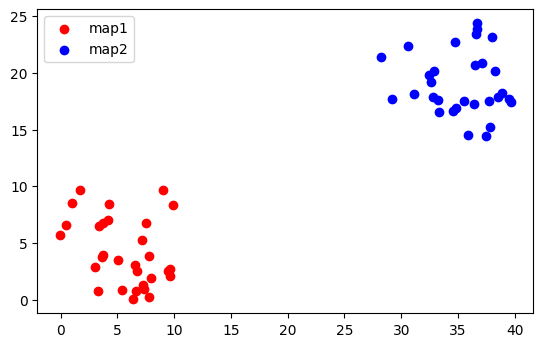

In [56]:
T = xypsi_2_transform(*(np.random.random((3,)) * np.array([50, 50, 2*np.pi])))
map2 = transform(T, map2_correct, stacked_axis=0)

fig, ax = plt.subplots()
ax.scatter(map1[:,0], map1[:,1], color='red')
ax.scatter(map2[:,0], map2[:,1], color='blue')
# for i in range(num_objs_overlap):
#     ax.plot([map1[i,0], map2[i,0]], [map1[i,1], map2[i,1]], color='lawngreen')
ax.legend(['map1', 'map2'])
ax.set_aspect('equal')

# Align frames with CLIPPER

In [57]:
frame_aligner = motlee.realign.frame_aligner.FrameAligner(
    method=motlee.realign.frame_aligner.AssocMethod.CLIPPER,
    num_objs_req=8,
    clipper_epsilon=.5,
    clipper_sigma=.5
)

Success: True
Transform: 
[[  0.948   0.318   0.    -33.436]
 [ -0.318   0.948   0.     -1.577]
 [  0.      0.      1.      0.   ]
 [  0.      0.      0.      1.   ]]
Num objects used: 13
Transform residual: 0.6584986673240162



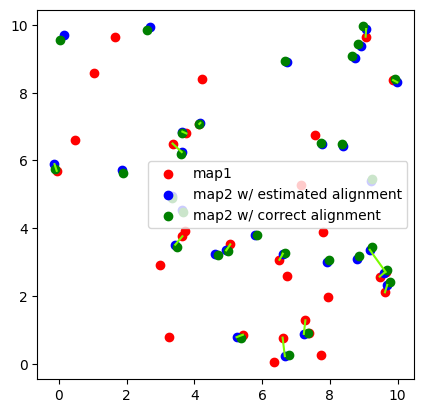

In [59]:
sol = frame_aligner.align_objects(static_objects=[map1, map2])
print(sol)
map2_frame_align = transform(sol.transform, map2, stacked_axis=0)
fig, ax = plt.subplots()
ax.scatter(map1[:,0], map1[:,1], color='red')
ax.scatter(map2_frame_align[:,0], map2_frame_align[:,1], color='blue')
ax.scatter(map2_correct[:,0], map2_correct[:,1], color='green')
for i in range(num_objs_overlap):
    ax.plot([map1[i,0], map2_frame_align[i,0]], [map1[i,1], map2_frame_align[i,1]], color='lawngreen')
ax.legend(['map1', 'map2 w/ estimated alignment', 'map2 w/ correct alignment'])
ax.set_aspect('equal')

# Align Frames with ICP

In [60]:
frame_aligner = motlee.realign.frame_aligner.FrameAligner(
    method=motlee.realign.frame_aligner.AssocMethod.ICP_STRONG_CORRES,
    num_objs_req=8,
    icp_max_dist=1.,
)

Success: True
Transform: 
[[  0.961   0.276   0.    -33.2  ]
 [ -0.276   0.961   0.     -3.27 ]
 [  0.      0.      1.      0.   ]
 [  0.      0.      0.      1.   ]]
Num objects used: 15
Transform residual: 17.786884772018023



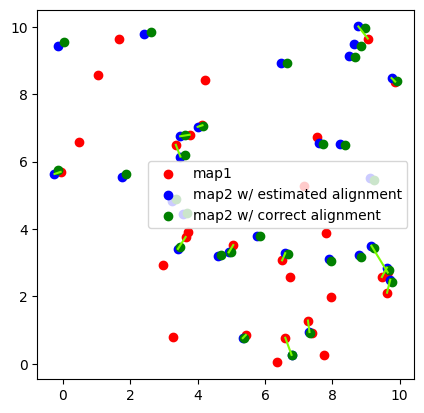

In [63]:
sol = frame_aligner.align_objects(static_objects=[map1, map2], T_init_guess=np.linalg.inv(T))
print(sol)
map2_frame_align = transform(sol.transform, map2, stacked_axis=0)
fig, ax = plt.subplots()
ax.scatter(map1[:,0], map1[:,1], color='red')
ax.scatter(map2_frame_align[:,0], map2_frame_align[:,1], color='blue')
ax.scatter(map2_correct[:,0], map2_correct[:,1], color='green')
for i in range(num_objs_overlap):
    ax.plot([map1[i,0], map2_frame_align[i,0]], [map1[i,1], map2_frame_align[i,1]], color='lawngreen')
ax.legend(['map1', 'map2 w/ estimated alignment', 'map2 w/ correct alignment'])
ax.set_aspect('equal')